<a href="https://colab.research.google.com/github/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/src/co2_forecasting_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     |████████████████████████████████| 1.5MB 6.1MB/s 
     |████████████████████████████████| 808kB 34.7MB/s 
     |████████████████████████████████| 8.7MB 37.3MB/s 
     |████████████████████████████████| 2.1MB 39.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


Start Program...
Loading .xlsx data...
LOADED DATA: type: <class 'pandas.core.frame.DataFrame'> shape: 540
            CO2 Levels
YEAR                  
1975-01-01      330.73
1975-02-01      331.46
1975-03-01      331.90
1975-04-01      333.17
1975-05-01      333.94


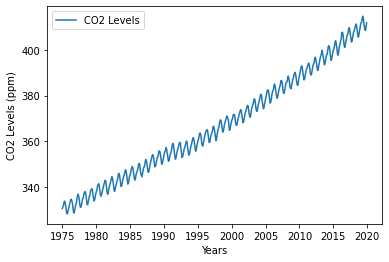

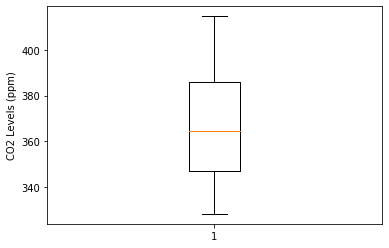

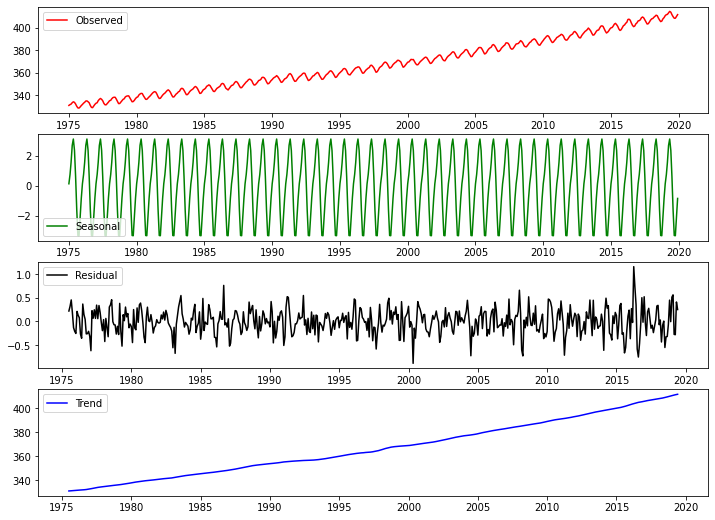

p-val: 1.0
data(orig) is_stationary: False
p-val: 0.00022540010467247346
data(diff) is_stationary: True
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=614.118, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=346.236, Time=2.05 sec


In [ ]:
! pip install pmdarima
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller


# Whole Dataset
DATASET = "https://github.com/nikhilparab17/Time-Series-Forecasting-for-CO2-Levels/blob/master/data/co2_dataset_preprocess.xlsx?raw=true"
CO2 = "https://github.com/nikhilparab17/ClimateChange-Analysis-and-Forecasting/blob/master/data/co2_monthly_process.xlsx?raw=true"



DEBUG_PRINTS=1

def loadExcelData(filepath):
    print("Loading .xlsx data...")
    excelData = pd.ExcelFile(filepath)
    data = excelData.parse()
    return data

def convert_datetime(data):
    data.index = data['YEAR'].apply(lambda x: dt.datetime.strptime(x, '%Y/%m/%d'))
    del data['YEAR']
    return data

def difference(data,order=1):
    data_diff = data.diff(order)
    return data_diff[order:]

def check_stationary(data):
    out = adfuller(data)
    p_val = out[1]
    print("p-val:", p_val)
    if p_val < 0.05:
        return True
    else:
        return False

def feature_visualization(data, feature1,feature2):

    tmp = data[feature1][data[feature1].notnull()]
    tmpp = data[feature2][data[feature2].notnull()]

    # time series
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(tmp.index, tmp, label = feature1+' (millions USD)', color='b')
    ax2.plot(tmpp.index, tmpp, label = feature2+' (USD)', color='g')

    ax1.set_xlabel('Years')
    ax1.set_ylabel(feature1+' (millions USD)', color='b')
    ax2.set_ylabel(feature2+' (USD)', color='g')

    ax1.legend(loc=3)
    plt.savefig(feature1 + feature2 + "_time-series.png")
    plt.show()
    plt.close()
    #vals = ax2.get_yticks()
    #ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


def data_visualization(data, feature):

    tmp = data[feature][data[feature].notnull()]

    # time series
    plt.plot(tmp.index, tmp, label = feature)
    plt.legend()
    plt.xlabel("Years")
    plt.ylabel(feature + " (ppm)")
    plt.savefig(feature + "_time-series.png")
    plt.show()
    plt.close()

    # box plot
    plt.boxplot(tmp)
    plt.ylabel(feature + " (ppm)")
    plt.savefig(feature +"_boxplot.png")
    plt.show()
    plt.close()

    # seasonal decomposition
    sd = seasonal_decompose(tmp, model= "additive")
    fig, ax = plt.subplots(4,figsize=(12,9))
    ax[0].plot(sd.observed, color='red', label = "Observed")
    ax[0].legend()
    ax[1].plot(sd.seasonal, color = 'green', label = "Seasonal")
    ax[1].legend()
    ax[2].plot(sd.resid, color = 'black', label = "Residual")
    ax[2].legend()
    ax[3].plot(sd.trend, color = 'blue', label= "Trend")
    ax[3].legend()
    fig.savefig(feature + "_seasonal_decompose.png")
    plt.show()
    plt.close()

# calculate 'p' using Auto Correlation Function(ACF)
def acf(x, feature = 'CO2 Levels', l=3):
    plot_acf(x[feature], lags=l)
    plt.xlabel("Lag")
    plt.savefig("CO2_ACF.png")
    plt.close()

# calculate 'q' using Partial Auto Correlation Function(PACF)
def pacf(x, feature ='CO2 Levels', l=3):
    plot_pacf(x[feature], lags=l)
    plt.xlabel("Lag")
    plt.savefig("CO2_PACF.png")
    plt.close()

# ARIMA
def arima(x,coef):
    stepwise_model= auto_arima(x, exogenous=None, start_p=0, d=1, start_q=0,
                                max_p=3, max_d=1, max_q=3,
                                start_P=0, D=1, start_Q=0, max_P=3, max_D=3, max_Q=3, max_order=10, m=12, seasonal=True,
                                trace=True,error_action='ignore',suppress_warnings=True,stepwise=False,approximation=False)

    print(stepwise_model.aic())
    print(stepwise_model.summary())

    split=len(x) - int(coef * len(x))
    train = x[0:split]
    test = x[split:]

    stepwise_model.fit(train)

    future_forecast = stepwise_model.predict(n_periods=len(test))
    future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Prediction'])
    lineObjects=plt.plot(pd.concat([test, future_forecast], axis=1))
    plt.xlabel("Years")
    plt.ylabel("CO2 Levels (ppm)")
    plt.legend(iter(lineObjects), ('CO2 Levels', 'Predictions'))
    plt.savefig("Forecast.png")
    plt.show()
    plt.close()

    line1bjects=plt.plot(pd.concat([x, future_forecast], axis=1))
    plt.xlabel("Years")
    plt.ylabel("CO2 Levels (ppm)")
    plt.legend(iter(line1bjects), ('CO2 Levels', 'Predictions'))

    plt.savefig("Forecast_conc.png")
    plt.show()
    plt.close()

    pred_error = rmse(test, future_forecast)
    print("rmse:", pred_error)

    stepwise_model.plot_diagnostics(figsize=(15, 12))
    plt.savefig("Diagnostic.png")
    plt.show()
    plt.close()

def main():
    print('Start Program...')

    # data-loading
    co2_data = loadExcelData(CO2)
    if DEBUG_PRINTS:
        print("LOADED DATA: type:", type(co2_data), "shape:", len(co2_data))

    # pre-process (convert to date-time series)
    co2_df = convert_datetime(co2_data)
    print(co2_df.head())

    # data visualization
    data_visualization(co2_df, "CO2 Levels")
    acf(co2_df, l=30)
    pacf(co2_df, l=30)

    # check stationarity
    is_stationary = check_stationary(co2_df)
    print("data(orig) is_stationary:", is_stationary)
    if is_stationary == False:
       co2_dif = difference(co2_df, 1)
       is_diff_stationary = check_stationary(co2_dif)
       if is_diff_stationary == True:
          print("data(diff) is_stationary:", is_diff_stationary)

    # ARIMA
    arima(co2_df,0.2)

   # GDP, Crude OIL Feature visualization
  #co2_data_f = loadExcelData(DATASET)
  # co2_df_f = convert_datetime(co2_data_f)
  #feature_visualization(co2_df_f, "GDP", "Crude Oil")

    print('End Program...')

if __name__ == '__main__':
    main()



